In [14]:
######################################################################################################################
######################################################################################################################
# This defines the functions needed to detect anomalies in the spending budget of a client at the                   ##
# master advertiser level. The input is the datasets written by master_adv_id_monthly.py                            ##
# that outputs the trend lines for each of the master_adv_ids on a monthly basis. The input                         ##
# can be tailored to include for example, only certain offers or other types of categorization.                     ##
#                                                                                                                   ##
# The seasonality persiod is calculated by taking a FFT of the time series. Details are                             ##
# given in checking_for_seasonality.ipynb available on Github.                                                      ##
#                                                                                                                   ##
# After having found the seasonality period, it detects anomalies in the time series                                ##
# for each master_adv_id. There are two main categories of anomalies we detect:                                     ##
#   1- Deviation from periodicity                                                                                   ##
#   2- Deviation from trend (has 4 sub-categories)                                                                  ##
#                                                                                                                   ##
# Deviation from periodicity is detected by looking at the peaks in the time series.                                ##
# If two consecutive peaks are more than twice the period apart, that shows a deviation                             ##
# from periodicity and the index of the first peak is recorded.                                                     ##
#                                                                                                                   ##
# Deviation from trend is detected in the following manner:                                                         ##
#   1- A seasonal decomposition is performed on the time series using the period calculated above.                  ##
#   2- The trend is extracted.                                                                                      ##
#   4- The trend is subtracted from the signal. This difference is called the residual.                             ##
#   5- Any point in time where the residual is larger than a threshold value is taken as                            ##
#      deviation in the signal. We define this value as a coefficient (named "threshold") times the rolling         ##
# 	   standard deviation of the residual.																			##
#                                                                                                                   ##
# We detect seven types of anomalies:                                                                               ##
#   1- Zero: When budget is zero for a short period (less than 2 months)                                            ##
#   2- Offline: When budget is zero for extended get_periods_and_anomaly                                            ##
#   3- Increase: Unexpected spike in budget                                                                         ##
#   4- Decrease: Unexpected dip in budget                                                                           ##
#   5- Amp. Decrease: Unexpected decrease in amplitude                                                              ##
#   6- Amp. Increase: Unexpected increase in amplitude                                                              ##
#   7- Season: Deviation from seasonality                                                                           ##
#                                                                                                                   ##
# NOTE: There is a special case of anomaly where the seasonality is unchanged but the amplitude increases or 		##
# decreases. This is different from unexpected and local spikes/dips. We detect this by running the trend 			##
# deviation algorithm on the series constructed from the exterma of the original time series. This is still 		##
# labled as amp_increase/decrease.	     																			##
#                                                                                                                   ##
# Dependencies:																										##
#	1- pandas																										##
# 	2- numpy																										##
#	3- scipy																										##
#	4- math 																										##
#	5- more_itertools                                                                                               ##
#	6- statsmodels 																									##
#                                                                                                                   ##
#                                                                                                                   ##
# Author: Farshad Nasiri - B2B Data Science team                                                                    ##
# Date: Dec-2018                                                                                                    ##
######################################################################################################################
######################################################################################################################

# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal
import math
from more_itertools import consecutive_groups
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
###############################
# Moving average function
# Moving average is computed by convolving a kernel of size=window
# and kernel elements of 1/window_size over the series.
def ma(array, window=1):  # Moving average
     return np.convolve(array[0], np.ones((1,window))[0]/window, mode='same').reshape(1,array.shape[1])

###############################    
# Pass a list to this function and it'll replace consequtive numbers
# with the first one. Example:
# my_list=[1, 4,5,6, 10, 15,16,17,18, 22, 25,26,27,28]
# returned list = [1,4,10,15,22,25]
def remove_index_sequences(indecies):
    clean_list=[]
    offline_index=[]
    for group in consecutive_groups(indecies):
        temp=list(group)
        clean_list.append(temp[0])
        if len(temp) >=2:
            offline_index.append(temp[0])

    return clean_list, offline_index

###############################
# Removes sequences of the same anomaly type in the temp_df. See below.
def remove_sequences_df(data_frame):
    # Remove consequtive anomalies and leave only the first index
    dict={'zero':1000, 'increase':2000, 
          'decrease':3000, 'offline':4000, 
          'season':5000, 'amp_decrease':6000, 'amp_increase':7000}
    data_frame['aux_col']=data_frame.anomaly_type.replace(dict)+pd.to_numeric(data_frame.anomaly_index)
    
    seq, offline=remove_index_sequences(list(data_frame.aux_col))
    data_frame=data_frame[data_frame.aux_col.isin(seq)]
    
    col=data_frame['anomaly_type'].copy()
    mask = data_frame.aux_col.isin(offline)
    col.update(col.loc[mask].replace('zero','offline'))
    data_frame['anomaly_type']=col
    data_frame.drop(columns=['aux_col'], axis=1, inplace=True)
    data_frame.reset_index(drop=True, inplace=True)

    return data_frame

################################################################
# Detecting deviation from seasonality #########################
################################################################
def seasonality_deviation(time_series, mov_avg_window, original_signal):
    # time_series is original_signal with heading and trailing zeors removed!
    hold_it=original_signal
    # Adjust the moving average window size if time series
    # has fewer points than mov_avg_window
    if time_series.shape[1] < mov_avg_window:
        ma_window=time_series.shape[1]
    else:
        ma_window=mov_avg_window

    # Remove trend from the time series using moving average    
    ts_no_trend=time_series-ma(time_series, window=ma_window)

    ################################################################
    # Seasonality detection. Refer to header for more information. #
    ################################################################
    # Next largest power of 2        
    nfft=1<<(time_series.shape[1]-1).bit_length()

    # Performing FFT and rescaling
    y=np.fft.fft(ts_no_trend, n=nfft)
    y=abs(y**2)
    y=(y-y.min())
    y=y/y.max() # Power spectrum

    # Creating the half frequency range
    freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
    freq_ts=freq_ts.reshape(-1,1)

    y=y[0][0:int(nfft/2)].reshape(1,-1).T # Throwing away the second half

    # Saving the period
    if y.size != 0:
        print(y.size)
        if (1/freq_ts[ np.argmax(y) ])[0] != np.inf:
            ts_period=( math.ceil((1/freq_ts[ np.argmax(y) ])[0]) )
    else:
        ts_period=1000 # Arbitrary large number if no periodicity
    
    # Once we're done with period calculation, put the trailing zeros back
    time_series=hold_it.copy()

    ################################################################
    # Detecting deviation from periodicity #########################
    ################################################################

    # Get the locations of the peaks in the time series
    peaks=scipy.signal.find_peaks(time_series[0])
    peaks=peaks[0] # Reshape

    
    temp_flags=[] # Saves the locations of anomalies for the given time series.
    temp_types=[] # Saves the type of anomalies for the time series.
    # Loop through the list of peaks and see if there are any two 
    # consecutive peaks that are apart more than twice the period.	
    if len(peaks) >=2:
        for j in range(1,len(peaks)):
            if ( (peaks[j]-peaks[j-1])/ts_period >= 2 ):
                temp_flags.append(peaks[j-1])
                temp_types.append('season')
                
    return temp_flags, ts_period, time_series, temp_types

################################################################
# Detecting deviation from trend ###############################
################################################################
def trend_deviation(time_series, series_period, threshold, mov_avg_window):
    # time_series is the signal as it was originlly
    # threshold is the threshold of deviation from signal residulals std: theshold*std(residuals)
    temp_flags=[] # Saves the locations of anomalies for the given time series.
    temp_types=[] # Saves the type of anomalies for the time series.
    temp_ratio=[] # Saves the ratio of spike/dip to the local STD. For other types of anomaly, this is zero.
    if time_series.shape[1] < mov_avg_window:
        ma_window=time_series.shape[1]
    else:
        ma_window=mov_avg_window

    
    if len(time_series[0]) >= 2:
        # Performing seasonal decomposition
        if len(time_series[0]) <= series_period:
            decomposed=seasonal_decompose(time_series[0], freq=len(time_series[0])-1)
        else:
            decomposed=seasonal_decompose(time_series[0], freq=series_period)
        trend=decomposed.trend.reshape(1,-1)

        # Trend sometimes returns NaN valuse at the begining and end of a series.
        # We replace them with the closest non-NaN value.
        index_ind=0
        for i in range(0,trend.shape[1]):
            if ~np.isnan(trend[0][i]):
                index_ind=i
                break

        trend[0][0:index_ind]=trend[0][index_ind]

        trend=np.fliplr(trend)

        index_ind=0
        for i in range(0,trend.shape[1]):
            if ~np.isnan(trend[0][i]):
                index_ind=i
                break

        trend[0][0:index_ind]=trend[0][index_ind]

        trend=np.fliplr(trend)
        trend=trend.reshape(-1,)


        residuals = time_series[0]-trend
        # One last check for middle NaNs. Removing by interpolation. Supposes there 
        # are no sequences of NaNs in the middle of the time series.
        if np.isnan(residuals).sum() != 0: # Check if there are in fact NaN values
            nan_indecies=np.argwhere(np.isnan(residuals)) # If yes, find their indecies
            for ind in nan_indecies:
                residuals[index_ind]=0.5*(residuals[index_ind+1]+residuals[index_ind-1])


        rolling_std=pd.Series(residuals)
        rolling_std=rolling_std.rolling(ma_window).std()
        rolling_std.fillna(value=rolling_std.mean(), inplace=True)
        rolling_std=np.array(rolling_std)


        # Checking for deviation
        for j in range(0,len(residuals)):
            if abs(residuals[j]) > threshold*abs(rolling_std[j]):
                temp_flags.append(j)
                temp_ratio.append( abs(residuals[j]/rolling_std[j]) )
                if residuals[j] < 0:
                    temp_types.append('decrease')
                else:
                    temp_types.append('increase')

    return temp_flags, temp_types, temp_ratio

# Finds the indecies where budget became zero
def find_zeros(time_series):
    temp_flags=list(np.where(time_series<10.0)[0])
    temp_types=[]
    for i in temp_flags:
        temp_types.append('zero')
    return temp_flags, temp_types

################################################################
# Main function ################################################
################################################################
# Function to detect periodicity and anomaly
# dataframe:        input data frame
# mov_avg_window:   window size for moving average (int)
# threshold:        threshold for trend deviation 

def get_periods_and_anomaly(data_frame, mov_avg_window, threshold):
    
    period=[] # List to save periods of all advertisers
    flags=[]  # List to save indecied of anomalies of all advertisers 
    types=[]  # List to save the type of anomaly
    ratios=[] # List to save the ratio of spike/dip to the local STD. For other types of anomaly, this is zero.
    ma_window=mov_avg_window
    # Loops through all clients
    for i in range(0, len(data_frame.index)):
        
        location=i
        print(location)
        # Create a time series from the dataframe row
        time_series=np.array(data_frame.iloc[location,:]).reshape(1,-1)
        
        # Remove heading zeros --> Heading zeros mean the business wasn't a client yet
        index=(time_series != 0).argmax()
        time_series=time_series[0][index:].reshape(1,-1)
        
        hold_it=time_series.copy()# Save the time series with the trailing zeros

        # Remove trailing zeros --> Means the client really left
        # we remove those zeros so that they wouldn't contaminate 
        # the calculation of seasonality period.
        time_series[0]=time_series[0][::-1]
        index=(time_series != 0).argmax()
        time_series=time_series[0][index:].reshape(1,-1)
        time_series[0]=time_series[0][::-1]
        
        # Find the instances of deviation from seasonality
        temp_list2, main_period, time_series, temp_types2= \
        seasonality_deviation(time_series, mov_avg_window,hold_it)

        period.append(main_period) # Save the period
        
        # Find the instances of deviation from trend
        temp_list3, temp_types3, temp_ratio3=trend_deviation(time_series, main_period, threshold, ma_window)
        

        # Here we try to detect devation of amplitude by running the trend 
        # deviation algorithm on the peaks and troughs
        peaks=scipy.signal.find_peaks(time_series[0])
        peaks=peaks[0] # Reshape

        troughs=scipy.signal.find_peaks(-time_series[0])
        troughs=troughs[0]

        extermas=np.append(peaks,troughs)
        extermas.sort()
        
        if len(extermas)>=2:
            temp_list4, temp_types4, temp_ratio4= \
            trend_deviation(time_series[0][extermas].reshape(1,-1),main_period,threshold, ma_window)
           # print(i, temp_types4)
            temp_list4=list(extermas[temp_list4])
            temp_types4=list(temp_types4)
            
            temp_types4=[x.replace('decrease', 'amp_decrease') for x in temp_types4]
            temp_types4=[x.replace('increase', 'amp_increase') for x in temp_types4]
        else:
            temp_list4=[]
            temp_types4=[]
            temp_ratio4=[]
        # Find the instances budget became zero
        temp_list1, temp_types1=find_zeros(time_series[0])

        
        #print(i, len(temp_types4),len(temp_ratio4),len(temp_types3),len(temp_ratio3))
        
        # Combine all
        temp_list1=temp_list1+temp_list2
        temp_types1=temp_types1+temp_types2

        temp_ratios=list(np.zeros(len(temp_list1)))

        temp_list1=temp_list1+temp_list3+temp_list4
        temp_types1=temp_types1+temp_types3+temp_types4
        temp_ratios=temp_ratios+temp_ratio3+temp_ratio4



        # Getting unique values - We need to remove the repeatative values
        # saving in a dataframe makes this easy
        if len(temp_list1) != 0:
            # Create the dataframe

            #print(i,len(temp_list1),len(temp_types1),len(temp_ratios))

            temp_df=pd.DataFrame(data=np.array([temp_list1, temp_types1, temp_ratios]).T, 
                                     columns=['anomaly_index', 'anomaly_type', 'ratio'])
            temp_df.anomaly_index=pd.to_numeric(temp_df.anomaly_index)
            temp_df.ratio=pd.to_numeric(temp_df.ratio)
            temp_df.sort_values(by=['anomaly_index', 'anomaly_type'], inplace=True)
            # Drop duplicate indecies if any
            temp_df.drop_duplicates(subset=['anomaly_index'], keep='last', inplace=True)
            temp_df.reset_index(drop=True, inplace=True)
            temp_df.anomaly_index=pd.to_numeric(temp_df.anomaly_index)
            temp_df.sort_values(by=['anomaly_index'], inplace=True)
            temp_df.reset_index(drop=True, inplace=True)
            
            # Remove sequences of the same anomaly type
            temp_df=remove_sequences_df(temp_df)
    
            # Stage for export
            temp_flags=list(temp_df['anomaly_index'])
            temp_types=list(temp_df['anomaly_type'])
            temp_ratios=list(temp_df['ratio'])
        else:
            temp_flags=[]
            temp_types=[]
            temp_ratios=[]
        
        flags.append(temp_flags)
        types.append(temp_types)
        ratios.append(temp_ratios)
        
    return period, flags, types, ratios

In [15]:
f='../data/master_adv_id_monthly.csv'
# Count the lines
num_lines = sum(1 for l in open(f))

# Sample size - in this case ~10%
size = int(num_lines / 1000)

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = np.random.randint(low=1, high=num_lines, size=size)


df=pd.read_csv('../data/master_adv_id_monthly.csv', skiprows=list(range(0,22714)), nrows=5)
#df=pd.read_csv('../data/master_adv_id_monthly.csv',  nrows=50)
#df=pd.read_csv('../data/master_adv_id_monthly.csv')
master_period, master_flags, master_types,ratios=get_periods_and_anomaly(df, 4, 1.5)

0
64
1
64
2
3
64
4
64


In [16]:
pd.set_option("display.max_columns",100)
df.head(10)

,0.0,0.0.1,0.0.2,0.0.3,0.0.4,0.0.5,0.0.6,0.0.7,0.0.8,0.0.9,0.0.10,0.0.11,0.0.12,2860.7142857142853,929.0322580645161,0.0.13,0.0.14,0.0.15,0.0.16,0.0.17,0.0.18,0.0.19,0.0.20,0.0.21,0.0.22,0.0.23,0.0.24,0.0.25,0.0.26,0.0.27,0.0.28,0.0.29,0.0.30,0.0.31,0.0.32,0.0.33,0.0.34,0.0.35,0.0.36,0.0.37,0.0.38,0.0.39,0.0.40,0.0.41,0.0.42,0.0.43,0.0.44,0.0.45,0.0.46,0.0.47,...,0.0.69,0.0.70,0.0.71,0.0.72,0.0.73,0.0.74,0.0.75,0.0.76,0.0.77,0.0.78,0.0.79,0.0.80,0.0.81,0.0.82,0.0.83,0.0.84,0.0.85,0.0.86,0.0.87,0.0.88,0.0.89,0.0.90,0.0.91,0.0.92,0.0.93,0.0.94,0.0.95,0.0.96,0.0.97,0.0.98,0.0.99,0.0.100,0.0.101,0.0.102,0.0.103,0.0.104,0.0.105,0.0.106,0.0.107,0.0.108,0.0.109,0.0.110,0.0.111,0.0.112,0.0.113,0.0.114,0.0.115,0.0.116,0.0.117,76622
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,51800.000000,7290.322581,6571.428571,10870.967742,7933.333333,7677.419355,12000.000000,14387.096774,4129.032258,3200.000000,2048.387097,0.000000,16466.666667,0.000000,0.000000,12000.000000,0.000000,0.000000,5400.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76623
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,754.000000,1456.000000,1459.354839,1699.285714,1635.483871,1612.000000,1679.354839,1966.666667,1806.451613,1967.741935,2066.666667,1967.741935,1933.333333,1833.333333,1838.709677,2000.000000,903.225806,966.666667,967.741935,1033.333333,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76624
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76625
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3676.666667,1066.666667,4348.387097,2542.057143,5702.064516,2536.213333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76626
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1140.000000,2377.419355,2764.285714,2551.612903,2513.333333,2461.290323,2610.000000,2458.064516,3080.645161,2636.666667,2203.225806,2343.333333,2376.666667,2558.064516,2378.571429,2167.741935,2193.333333,2093.548387,2716.666667,1561.290323,2832.258065,2416.666667,2054.83871,2370.0,2086.666667,2138.709677,2358.62069,2258.064516,2686.666667,2367.741935,2560.0,2441.935484,2283.870968,2456.666667,2641.935484,4064.666667,1466.666667,5216.451613,3612.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76628


In [11]:
location_of_interest=2

t=np.array(range(0,df.shape[1]))
time_series=df.iloc[location_of_interest,:]

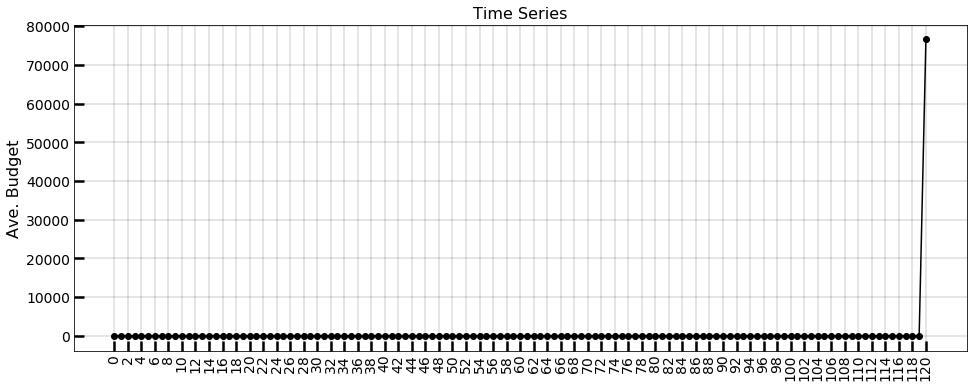

In [12]:
plt.figure(figsize=(16,6))
plt.cla()
plt.plot(t, time_series,'k-o', zorder=-1)
#plt.scatter(t[master_flags[location_of_interest]], time_series.values[master_flags[location_of_interest]],
#            c='r', s=100, zorder=2);
#plt.plot(t, abs(test[location_of_interest]),'r-o')
#plt.plot(t, test[location_of_interest],'g-o')
#plt.plot(t, trend_test[location_of_interest],'g')
#plt.plot([0,120],[1.5*test[location_of_interest].std(),1.5*test[location_of_interest].std()],'b')
plt.xticks(ticks=t[::2], rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time Series', fontsize=16);
plt.grid(linewidth=0.2)

In [13]:
time_series=np.array(time_series).reshape(1,-1)


decomposed=seasonal_decompose(time_series[0], freq=len(time_series[0])-1)

In [55]:
master_period[location_of_interest]

4

In [56]:
data_frame=pd.DataFrame(data=np.array([master_flags[location_of_interest],master_types[location_of_interest]]).T,
            columns=['Flag', 'Type'])
data_frame.Flag=pd.to_numeric(data_frame.Flag)

data_frame

,Flag,Type
0,0,decrease
1,16,amp_increase
2,17,increase
3,19,zero
4,21,zero
5,36,decrease
6,41,increase
7,44,amp_decrease
8,49,season
9,51,offline


In [175]:
data_frame=pd.DataFrame(data=np.array([master_flags[location_of_interest],master_types[location_of_interest]]).T,
            columns=['Flag', 'Type'])
data_frame.Flag=pd.to_numeric(data_frame.Flag)

col=data_frame['Type']
mask = col.groupby((col != col.shift()).cumsum()).transform('count').gt(3)
mask &= col.eq('zero')
col.update(col.loc[mask].replace('zero','offline'))
data_frame['Type']=col

dict={'zero':1000, 'increase':2000, 'decrease':3000, 'offline':4000, 'season':5000}
data_frame['aux_col']=data_frame.Type.replace(dict)
data_frame['aux_col2']=data_frame.Type.replace(dict)+data_frame.Flag

In [185]:
data_frame

,Flag,Type,aux_col,aux_col2
0,19,zero,1000,1019
1,21,zero,1000,1021
2,49,season,5000,5049
3,51,offline,4000,4051


In [156]:
def remove_sequences_df(data_frame):  
    # Remove consequtive anomalies and leave only the first index
    dict={'zero':1000, 'increase':2000, 'decrease':3000, 'offline':4000, 'season':5000}
    data_frame['aux_col']=data_frame.anomaly_type.replace(dict)+pd.to_numeric(data_frame.anomaly_index)

    print(list(data_frame.aux_col))
    
    seq, offline=remove_index_sequences(list(data_frame.aux_col))
    
    print(seq)
    data_frame=data_frame[data_frame.aux_col.isin(seq)]
    
    
    
    #data_frame=data_frame[data_frame.aux_col.shift() != data_frame.aux_col]
    data_frame.drop(columns=['aux_col'], axis=1, inplace=True)
    data_frame.reset_index(drop=True, inplace=True)
    
    return data_frame

In [157]:
d=np.array([[1,2,3,5,6,10],['zero','zero','zero','zero','zero','zero']])


data_frame=pd.DataFrame(data=d.T,columns=['anomaly_index', 'anomaly_type'])
data_frame.anomaly_index=pd.to_numeric(data_frame.anomaly_index)

In [158]:
data_frame

,anomaly_index,anomaly_type
0,1,zero
1,2,zero
2,3,zero
3,5,zero
4,6,zero
5,10,zero


In [159]:
remove_sequences_df(data_frame)

[1001, 1002, 1003, 1005, 1006, 1010]
[1001, 1002, 1003] 3
[1005, 1006] 2
[1010] 1
[1001, 1005, 1010]


,anomaly_index,anomaly_type
0,1,zero
1,5,zero
2,10,zero


In [160]:
for group in consecutive_groups([1001, 1002, 1003, 1005, 1006, 1010]):
    print(list(group)[0])

1001
1005
1010


In [161]:
remove_index_sequences([1001, 1002, 1003, 1005, 1006, 1010])

[1001, 1002, 1003] 3
[1005, 1006] 2
[1010] 1


([1001, 1005, 1010], [1001, 1005])

In [45]:
mylist=['ggg','lll']
mylist=[x.replace('ggg', 'aa') for x in mylist]

In [46]:
mylist

['aa', 'lll']